## Read database

In [ ]:
!pip install opendatasets

In [ ]:
import opendatasets as od

od.download(
	"https://www.kaggle.com/datasets/sobhanmoosavi/us-accidents")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: alirezarahhmati
Your Kaggle Key: ··········


100%|██████████| 653M/653M [00:06<00:00, 111MB/s]


In [ ]:
import pandas as pd
import random

In [ ]:
import dask.dataframe as dd

In [ ]:
full_df = dd.read_csv('/content/us-accidents/US_Accidents_March23.csv', assume_missing=True)

## Preproccessing

In [ ]:
full_df[]

In [ ]:
full_df.head()

,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-1,Source2,3.0,2016-02-08 05:46:00,2016-02-08 11:00:00,39.865147,-84.058723,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Night,Night,Night
1,A-2,Source2,2.0,2016-02-08 06:07:59,2016-02-08 06:37:59,39.928059,-82.831184,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Night,Night,Day
2,A-3,Source2,2.0,2016-02-08 06:49:27,2016-02-08 07:19:27,39.063148,-84.032608,NaN,NaN,0.01,...,False,False,False,False,True,False,Night,Night,Day,Day
3,A-4,Source2,3.0,2016-02-08 07:23:34,2016-02-08 07:53:34,39.747753,-84.205582,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Day,Day,Day
4,A-5,Source2,2.0,2016-02-08 07:39:07,2016-02-08 08:09:07,39.627781,-84.188354,NaN,NaN,0.01,...,False,False,False,False,True,False,Day,Day,Day,Day


In [ ]:
full_df.columns

Index(['ID', 'Source', 'Severity', 'Start_Time', 'End_Time', 'Start_Lat',
       'Start_Lng', 'End_Lat', 'End_Lng', 'Distance(mi)', 'Description',
       'Street', 'City', 'County', 'State', 'Zipcode', 'Country', 'Timezone',
       'Airport_Code', 'Weather_Timestamp', 'Temperature(F)', 'Wind_Chill(F)',
       'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Direction',
       'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Condition', 'Amenity',
       'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway',
       'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal',
       'Turning_Loop', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight',
       'Astronomical_Twilight'],
      dtype='object')

In [ ]:
full_df.isna().sum().compute()

ID                             0
Source                         0
Severity                       0
Start_Time                     0
End_Time                       0
Start_Lat                      0
Start_Lng                      0
End_Lat                  3402762
End_Lng                  3402762
Distance(mi)                   0
Description                    5
Street                     10869
City                         253
County                         0
State                          0
Zipcode                     1915
Country                        0
Timezone                    7808
Airport_Code               22635
Weather_Timestamp         120228
Temperature(F)            163853
Wind_Chill(F)            1999019
Humidity(%)               174144
Pressure(in)              140679
Visibility(mi)            177098
Wind_Direction            175206
Wind_Speed(mph)           571233
Precipitation(in)        2203586
Weather_Condition         173459
Amenity                        0
Bump      

## EDA

### Regression

In [ ]:
df = full_df[["Severity", "State", "Weather_Condition", "Temperature(F)", "Wind_Chill(F)", "Humidity(%)", "Pressure(in)",
              "Visibility(mi)", "Wind_Direction", "Wind_Speed(mph)", "Amenity", "Bump", "Crossing", "Give_Way", "Junction", "No_Exit", "Railway", "Roundabout",
              "Station", "Stop", "Traffic_Calming", "Traffic_Signal", "Turning_Loop", "Sunrise_Sunset", "Civil_Twilight", "Nautical_Twilight", "Astronomical_Twilight"]]

In [ ]:
# Calculate the mean for each column
column_means = df.mean()

# Use the calculated means to fill missing values in each column
df = df.fillna(column_means.compute())

In [ ]:
# Define the label for missing values in categorical columns
missing_category = "Unknown"

# Replace missing values with the specified label for categorical columns
categorical_columns = ["State", "Weather_Condition", "Wind_Direction", "Amenity", "Crossing", "Give_Way", "No_Exit", "Railway", "Roundabout", "Junction", "Station", "Traffic_Signal", "Turning_Loop", "Sunrise_Sunset", "Civil_Twilight", "Nautical_Twilight", "Astronomical_Twilight", "Bump", "Stop", "Traffic_Calming"]
for column in categorical_columns:
    df[column] = df[column].fillna(missing_category)

In [ ]:
# Ensure that the Dask DataFrame is re-categorized
df = dd.from_pandas(df.compute(), npartitions=1)

In [ ]:
# Use the categorize method for one-hot encoding
df = df.categorize(columns=categorical_columns)

# Now, you can use get_dummies to one-hot encode these columns
df = dd.get_dummies(df, columns=categorical_columns, drop_first=True)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Define the numerical columns to be scaled
numerical_columns = ["Severity", "Temperature(F)", "Humidity(%)", "Pressure(in)", "Visibility(mi)", "Wind_Speed(mph)"]

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Apply Min-Max scaling using Dask's map_partitions
def scale_partition(partition):
    return scaler.fit_transform(partition[numerical_columns])

df = df.map_partitions(scale_partition)

In [ ]:
!pip install dask-ml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.7/148.7 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.0/81.0 kB 7.7 MB/s eta 0:00:00


In [ ]:
from dask_ml.model_selection import train_test_split

# Split the data into a training set (70%) and a temporary set (30%)
train, test = train_test_split(df, train_size=0.8, test_size=0.2, random_state=42)

# Compute the Dask DataFrames to make them ready for analysis
train = train.compute()
test = test.compute()

TypeError: ignored

In [ ]:
from sklearn.linear_model import LinearRegression

# Define your target variable (dependent variable) and features (independent variables)
target_variable = 'Severity'
feature_columns = [col for col in train.columns if col != target_variable]

# Extract the features and target variable from the training data
X_train = train[feature_columns]
y_train = train[target_variable]

# Create a linear regression model
model = LinearRegression()

# Train the model on the training data
model.fit(X_train, y_train)

ValueError: ignored

### Weather Condition

In [ ]:
df = full_df.dropna(subset=["Weather_Condition"])

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

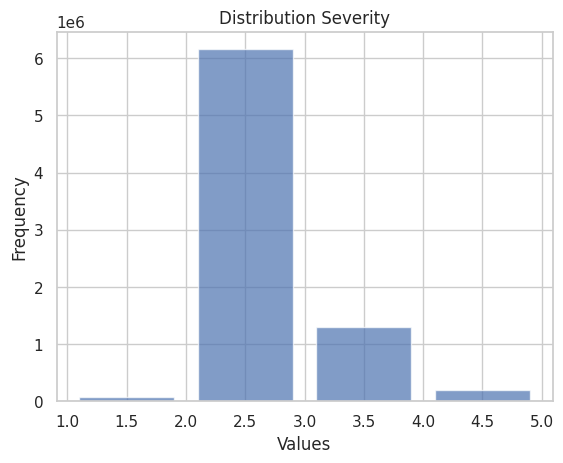

In [ ]:
import holoviews as hv

# Extract the column you want to plot
column_to_plot = full_df['Severity']

# Compute the values as a Pandas Series
column_data = column_to_plot.compute()

# Create a histogram plot using matplotlib
plt.hist(column_data, bins=[1, 2, 3, 4, 5], rwidth=0.8, alpha=0.7)
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Distribution Severity')

# Show the plot
plt.show()

In [ ]:
# Group data by weather condition and calculate the average severity for each condition
weather_groups = df.groupby('Weather_Condition')
average_severity_by_weather = weather_groups['Severity'].mean()

In [ ]:
average_severity_by_weather.compute()

Weather_Condition
Blowing Dust / Windy         2.101504
Blowing Sand                 2.500000
Blowing Snow                 2.286486
Clear                        2.367950
Cloudy                       2.160340
                               ...   
Sand / Windy                 2.000000
Heavy Rain Shower / Windy    2.000000
Blowing Snow Nearby          2.000000
Drifting Snow                2.000000
Heavy Rain Shower            2.333333
Name: Severity, Length: 144, dtype: float64

In [ ]:
# Group data by weather condition and calculate the total number of accidents and average severity for each condition
weather_groups = df.groupby('Weather_Condition')
weather_stats = weather_groups.agg({'Severity': 'mean', 'ID': 'count'})

# Sort the weather conditions based on average severity and total accident count
sorted_weather_stats = weather_stats.sort_values(by=['Severity', 'ID'], ascending=[False, False])

sorted_weather_stats.compute()

,Severity,ID
Weather_Condition,,
Light Blowing Snow,3.666667,3
Patches of Fog / Windy,3.142857,7
Light Fog,3.000000,4
Heavy Freezing Rain / Windy,3.000000,1
Partial Fog / Windy,3.000000,1
...,...,...
Heavy Rain Shower / Windy,2.000000,1
Blowing Snow Nearby,2.000000,1
Drifting Snow,2.000000,1


In [ ]:
import numpy as np

# Calculate mean and standard deviation of severity for all accidents
all_severity_mean = np.mean(full_df['Severity'])
all_severity_std = np.std(full_df['Severity'])

all_severity_std.compute()

0.48753130239446674

In [ ]:
import numpy as np
from scipy.stats import norm

most_accidents_weather = "Light Blowing Snow";

# Extract the severity values for the specific weather condition
severity_specific_weather = df[df['Weather_Condition'] == most_accidents_weather]['Severity']

# Sample mean and standard deviation for the specific weather condition
sample_mean = np.mean(severity_specific_weather)
sample_std = np.std(severity_specific_weather)

# Calculate the z-score
z_score = (sample_mean - all_severity_mean) / (all_severity_std / np.sqrt(len(severity_specific_weather)))

# Calculate the p-value
p_value = 1 - norm.cdf(z_score)

# Interpret the result
if p_value < 0.05:  # Set your significance level (e.g., 0.05)
    print(f"The mean severity in the weather condition '{most_accidents_weather}' is significantly higher than the overall mean severity.")
else:
    print(f"There is no significant difference in mean severity between the weather condition '{most_accidents_weather}' and all accidents.")


The mean severity in the weather condition 'Light Blowing Snow' is significantly higher than the overall mean severity.


In [ ]:
p_value

1.1918044295899932e-07

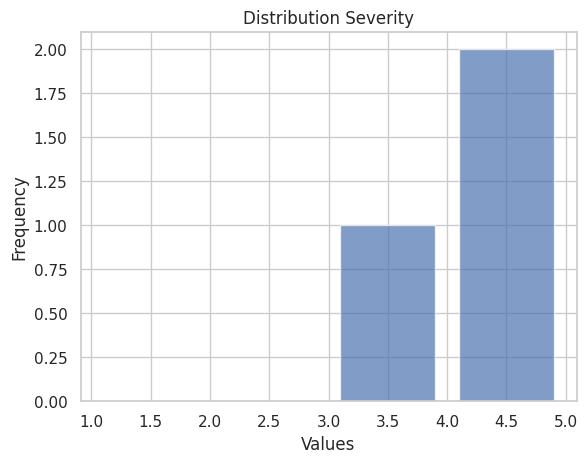

In [ ]:
import holoviews as hv

# # Extract the column you want to plot
# column_to_plot = df['Severity']

# Compute the values as a Pandas Series
column_data = severity_specific_weather.compute()

# Create a histogram plot using matplotlib
plt.hist(column_data, bins=[1, 2, 3, 4, 5], rwidth=0.8, alpha=0.7)
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Distribution Severity')

# Show the plot
plt.show()

### State

In [ ]:
df = full_df.dropna(subset=["State"])

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Group data by weather condition and calculate the average severity for each condition
time_groups = df.groupby('State')
average_severity_by_time = time_groups['Severity'].mean()

In [ ]:
average_severity_by_time.compute()

State
CA    2.165688
FL    2.140060
GA    2.506931
IA    2.419432
IL    2.383302
IN    2.398072
MO    2.399609
NE    2.180672
OH    2.353698
SC    2.111055
WI    2.473939
WV    2.157181
CT    2.347032
DC    2.143639
DE    2.254309
KY    2.454176
MA    2.293842
MD    2.332702
MI    2.337318
NH    2.243317
NJ    2.233750
NY    2.259550
OR    2.112407
PA    2.205765
RI    2.458252
TX    2.224124
VA    2.278974
WA    2.344138
AL    2.242637
AR    2.276295
AZ    2.119536
CO    2.443902
KS    2.328077
LA    2.126459
ME    2.203855
MN    2.162018
MS    2.344312
NC    2.133824
NM    2.372107
NV    2.230879
OK    2.077313
TN    2.198061
UT    2.181914
VT    2.425486
ID    2.115682
ND    2.013479
WY    2.339633
MT    2.037233
SD    2.442907
Name: Severity, dtype: float64

In [ ]:
# Group data by weather condition and calculate the total number of accidents and average severity for each condition
time_groups = df.groupby('State')
time_stats = time_groups.agg({'Severity': 'mean', 'ID': 'count'})

# Sort the weather conditions based on average severity and total accident count
sorted_time_stats = time_stats.sort_values(by=['Severity', 'ID'], ascending=[False, False])

sorted_time_stats.compute()

,Severity,ID
State,,
GA,2.506931,169234
WI,2.473939,34688
RI,2.458252,16971
KY,2.454176,32254
CO,2.443902,90885
SD,2.442907,289
VT,2.425486,926
IA,2.419432,26307
MO,2.399609,77323


In [ ]:
# Calculate mean and standard deviation of severity for all accidents
all_severity_mean = np.mean(full_df['Severity'])
all_severity_std = np.std(full_df['Severity'])

all_severity_std.compute()

0.48753130239446674

In [ ]:
all_severity_mean.compute()

2.212384487643875

In [ ]:
most_accidents_time = "GA";

# Extract the severity values for the specific weather condition
severity_specific_time = df[df['State'] == most_accidents_time]['Severity']

# Sample mean and standard deviation for the specific weather condition
sample_mean = np.mean(severity_specific_time)
sample_std = np.std(severity_specific_time)

# Calculate the z-score
z_score = (sample_mean - all_severity_mean) / (all_severity_std / np.sqrt(len(severity_specific_time)))

# Calculate the p-value
p_value = 1 - norm.cdf(z_score)

# Interpret the result
if p_value < 0.05:  # Set your significance level (e.g., 0.05)
    print(f"The mean severity in the weather condition '{most_accidents_time}' is significantly higher than the overall mean severity.")
else:
    print(f"There is no significant difference in mean severity between the weather condition '{most_accidents_time}' and all accidents.")

The mean severity in the weather condition 'GA' is significantly higher than the overall mean severity.


In [ ]:
p_value

0.0

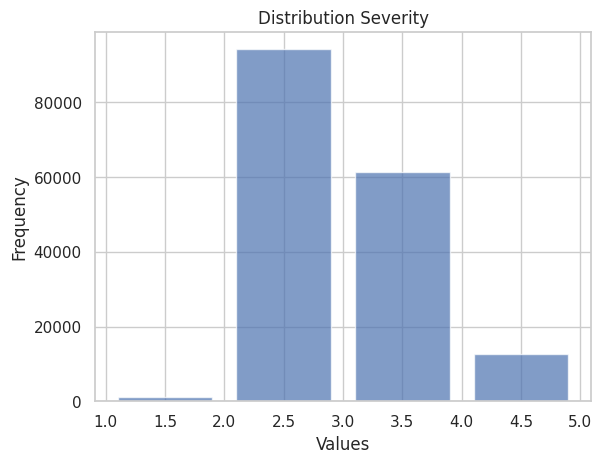

In [ ]:
import holoviews as hv

# # Extract the column you want to plot
# column_to_plot = df['Severity']

# Compute the values as a Pandas Series
column_data = severity_specific_time.compute()

# Create a histogram plot using matplotlib
plt.hist(column_data, bins=[1, 2, 3, 4, 5], rwidth=0.8, alpha=0.7)
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Distribution Severity')

# Show the plot
plt.show()

### Stop and Traffic Calming

In [ ]:
df = full_df

In [ ]:
# Assuming 'Stop' and 'Traffic_Calming' are binary columns (0 or 1)
stop_accidents = df[df['Stop'] == 1]
traffic_calming_accidents = df[df['Traffic_Calming'] == 1]


In [ ]:
stop_accident_count = len(stop_accidents)
traffic_calming_accident_count = len(traffic_calming_accidents)

In [ ]:
stop_average_severity = stop_accidents['Severity'].mean().compute()
traffic_calming_average_severity = traffic_calming_accidents['Severity'].mean().compute()

In [ ]:
# Compare accident counts
if stop_accident_count > traffic_calming_accident_count:
    print("Accidents near 'Stop' locations have a higher count.")
elif traffic_calming_accident_count > stop_accident_count:
    print("Accidents near 'Traffic_Calming' locations have a higher count.")
else:
    print("Accident counts are similar for 'Stop' and 'Traffic_Calming' locations.")

# Compare average severity
if stop_average_severity > traffic_calming_average_severity:
    print("Accidents near 'Stop' locations have a higher average severity.")
elif traffic_calming_average_severity > stop_average_severity:
    print("Accidents near 'Traffic_Calming' locations have a higher average severity.")
else:
    print("Average severity is similar for 'Stop' and 'Traffic_Calming' locations.")


Accidents near 'Stop' locations have a higher count.
Accidents near 'Traffic_Calming' locations have a higher average severity.


In [ ]:
print("traffic_calming_average_severity : " ,traffic_calming_average_severity)
print("stop_average_severity : " , stop_average_severity)

traffic_calming_average_severity :  2.1268754935509344
stop_average_severity :  2.076418918603729


In [ ]:
print("traffic_calming_accident_count : ", traffic_calming_accident_count)
print("stop_accident_count : ", stop_accident_count)

traffic_calming_accident_count :  7598
stop_accident_count :  214371


### Visualizing

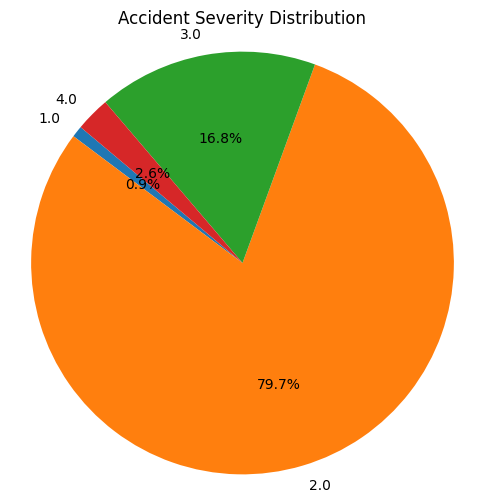

In [ ]:
ddf = full_df

# Group by severity and count the occurrences
severity_counts = ddf.groupby('Severity').size().compute()

# Create a pie chart
plt.figure(figsize=(6, 6))
plt.pie(severity_counts, labels=severity_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Accident Severity Distribution')
plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.

# Show the pie chart
plt.show()

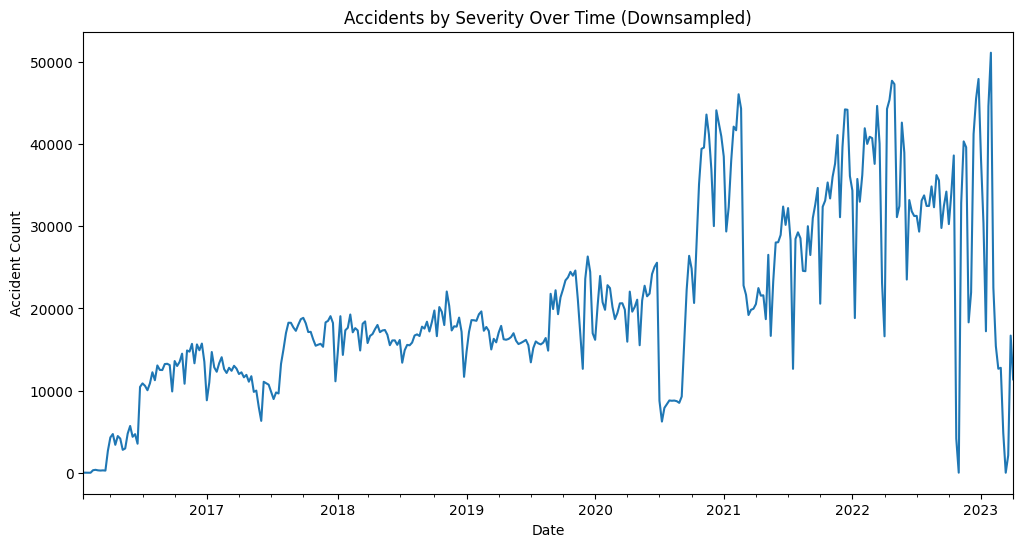

In [ ]:
import dask.dataframe as dd
import matplotlib.pyplot as plt

ddf = full_df

# Assuming you have a Dask DataFrame named 'ddf'
# Convert the 'Start_Time' column to a datetime format
ddf['Start_Time'] = dd.to_datetime(ddf['Start_Time'])

# Compute the daily accident count with Dask
daily_accident_count = ddf.groupby(ddf['Start_Time'].dt.date)['Severity'].count().compute()

# Convert the Dask Series to a Pandas DataFrame for resampling
# daily_accident_count = daily_accident_count.compute()
daily_accident_count.index = pd.to_datetime(daily_accident_count.index)  # Convert the index to a DateTimeIndex

# Downsample the data by resampling to a coarser time frequency, e.g., weekly
weekly_accident_count = daily_accident_count.resample('W').sum()

# Create a time series plot with downsampling
plt.figure(figsize=(12, 6))
weekly_accident_count.plot(x='Start_Time', y='Severity', title='Accidents by Severity Over Time (Downsampled)')
plt.xlabel('Date')
plt.ylabel('Accident Count')
plt.show()

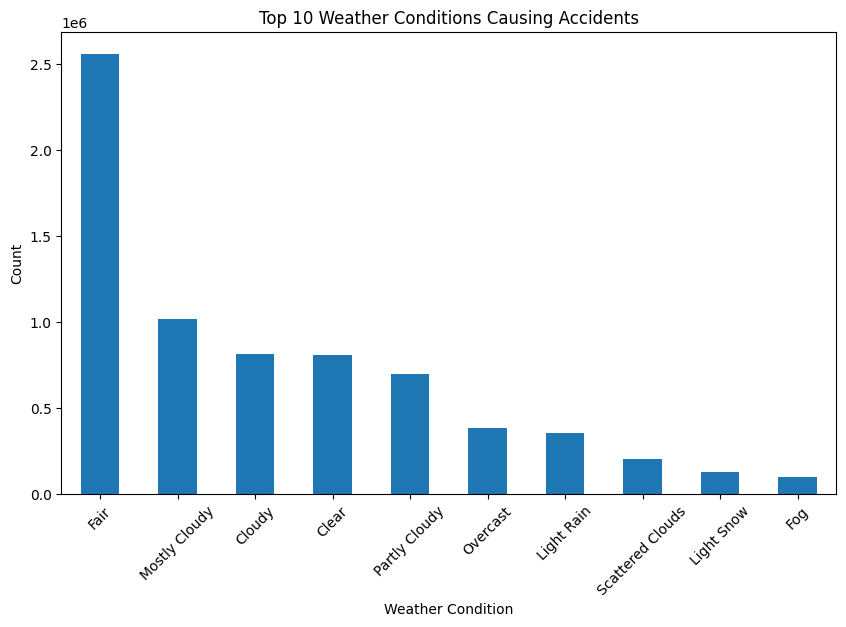

In [ ]:
import dask.dataframe as dd
import matplotlib.pyplot as plt

# Assuming your Dask DataFrame is named 'df'
df = full_df

# Group by the 'Weather_Condition' column and count the occurrences of each condition
weather_counts = df.groupby('Weather_Condition').size().compute()

# Sort the counts in descending order to find the most common causes
weather_counts = weather_counts.sort_values(ascending=False)

# Display the top N (e.g., top 10) weather conditions
N = 10
top_weather_conditions = weather_counts.head(N)

# Create a bar chart
plt.figure(figsize=(10, 6))
top_weather_conditions.plot(kind='bar')
plt.title(f"Top {N} Weather Conditions Causing Accidents")
plt.xlabel("Weather Condition")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()


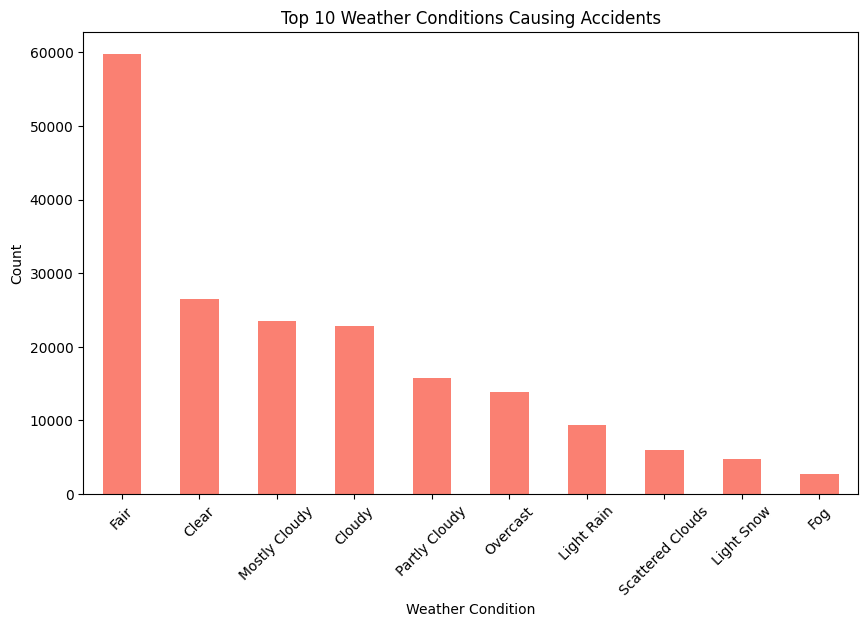

In [ ]:
# Assuming your Dask DataFrame is named 'df'
df = full_df

# Group by the 'Weather_Condition' column and count the occurrences of each condition
severity_filtered_df = df[df['Severity'] == 4]

weather_counts = severity_filtered_df.groupby('Weather_Condition').size().compute()

# Sort the counts in descending order to find the most common causes
weather_counts = weather_counts.sort_values(ascending=False)

# Display the top N (e.g., top 10) weather conditions
N = 10
top_weather_conditions = weather_counts.head(N)

# Create a bar chart
plt.figure(figsize=(10, 6))
top_weather_conditions.plot(kind='bar', color='salmon')
plt.title(f"Top {N} Weather Conditions Causing Accidents")
plt.xlabel("Weather Condition")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

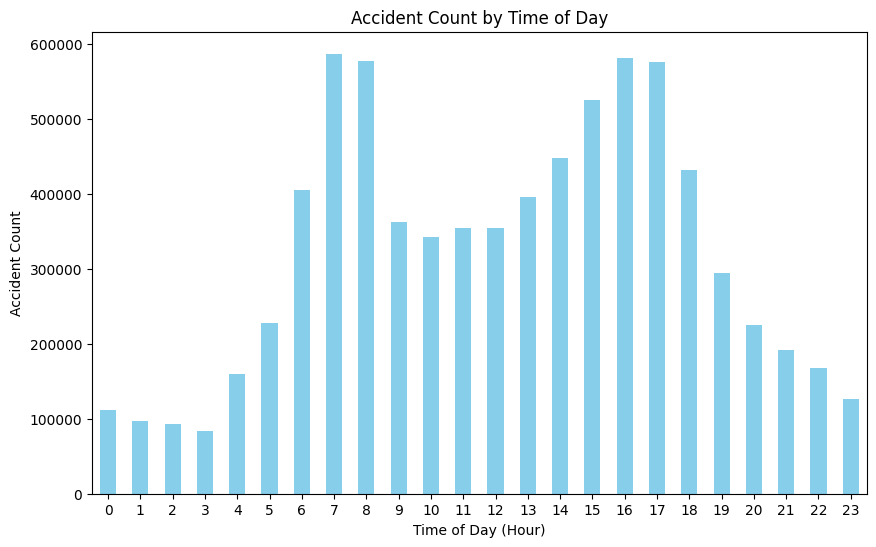

In [ ]:
ddf = full_df

# Assuming you have a Dask DataFrame named 'ddf' with columns 'Start_Time' and 'Severity'
# Convert the 'Start_Time' column to a Dask Series of the hour of the day
hour_of_day = ddf['Start_Time'].dt.hour

# Group the data by the hour of the day and calculate the count of accidents
hourly_accident_counts = hour_of_day.value_counts().compute()

# Sort the results by the hour of the day
hourly_accident_counts = hourly_accident_counts.sort_index()

# Create a bar chart
plt.figure(figsize=(10, 6))
hourly_accident_counts.plot(kind='bar', color='skyblue')
plt.xlabel('Time of Day (Hour)')
plt.ylabel('Accident Count')
plt.title('Accident Count by Time of Day')
plt.xticks(rotation=0)  # Rotate x-axis labels for better readability
plt.show()

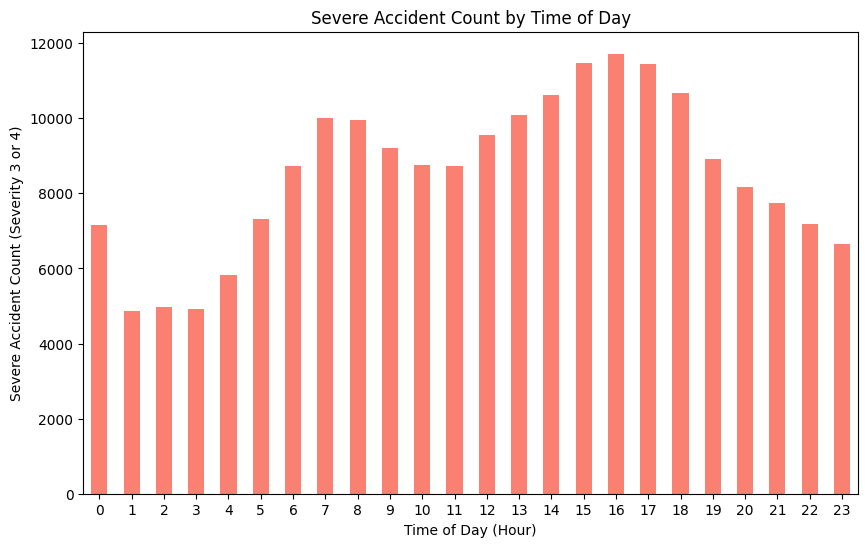

In [ ]:
ddf = full_df

# Assuming you have a Dask DataFrame named 'ddf' with columns 'Start_Time' and 'Severity'
# Filter the Dask DataFrame to include only accidents with severity 3 or 4
severity_filtered_ddf = ddf[ddf['Severity'] == 4]

# Convert the 'Start_Time' column to a Dask Series of the hour of the day
hour_of_day = severity_filtered_ddf['Start_Time'].dt.hour

# Group the filtered data by the hour of the day and calculate the count of severe accidents
hourly_severe_accident_counts = hour_of_day.value_counts().compute()

# Sort the results by the hour of the day
hourly_severe_accident_counts = hourly_severe_accident_counts.sort_index()

# Create a bar chart
plt.figure(figsize=(10, 6))
hourly_severe_accident_counts.plot(kind='bar', color='salmon')
plt.xlabel('Time of Day (Hour)')
plt.ylabel('Severe Accident Count (Severity 3 or 4)')
plt.title('Severe Accident Count by Time of Day')
plt.xticks(rotation=0)  # Rotate x-axis labels for better readability
plt.show()

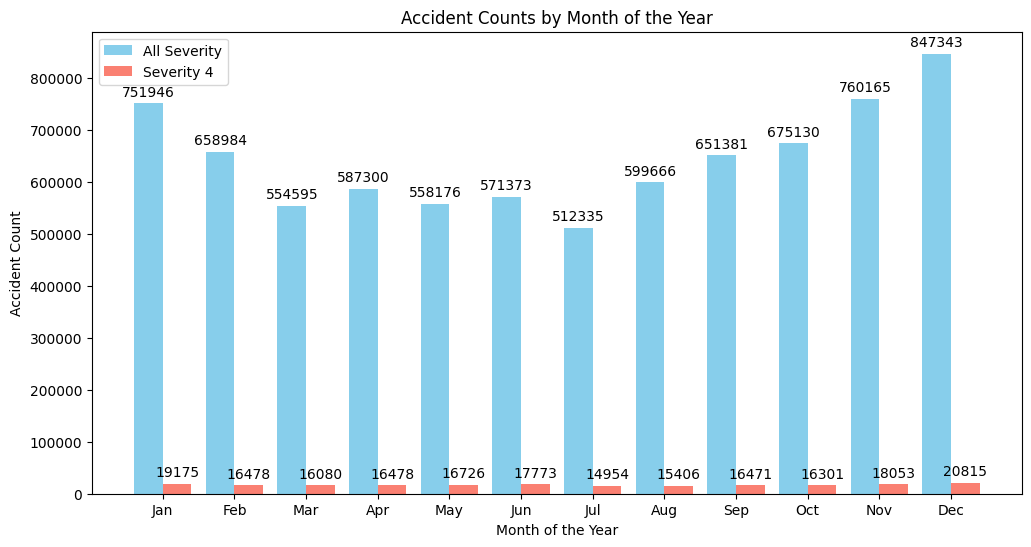

In [ ]:
ddf = full_df

# Assuming you have a Dask DataFrame named 'ddf' with columns 'Start_Time' and 'Severity'
# Convert the 'Start_Time' column to a Dask Series of the month of the year
month_of_year = ddf['Start_Time'].dt.month

# Group the data by the month of the year and calculate the count of all accidents
monthly_all_accident_counts = month_of_year.value_counts().compute()
monthly_all_accident_counts = monthly_all_accident_counts.sort_index()

# Filter the Dask DataFrame to include only accidents with severity level 4
severity_4_ddf = ddf[ddf['Severity'] == 4]

# Convert the 'Start_Time' column to a Dask Series of the month of the year for severity level 4
month_of_year_severity_4 = severity_4_ddf['Start_Time'].dt.month

# Group the filtered data by the month of the year and calculate the count of severity level 4 accidents
monthly_severity_4_accident_counts = month_of_year_severity_4.value_counts().compute()
monthly_severity_4_accident_counts = monthly_severity_4_accident_counts.sort_index()

# Create a bar chart with two bars for each month, showing all accidents and severity level 4 accidents
plt.figure(figsize=(12, 6))
width = 0.4
x = range(1, 13)

bars_all = plt.bar(x, monthly_all_accident_counts, width, label='All Severity', color='skyblue')
bars_severity_4 = plt.bar([i + width for i in x], monthly_severity_4_accident_counts, width, label='Severity 4', color='salmon')

plt.xlabel('Month of the Year')
plt.ylabel('Accident Count')
plt.title('Accident Counts by Month of the Year')

# Annotate each bar with its respective count
for bar in bars_all + bars_severity_4:
    height = bar.get_height()
    plt.annotate(f'{height}',
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3),  # 3 points vertical offset
                 textcoords="offset points",
                 ha='center', va='bottom')

plt.xticks([i + width / 2 for i in x], ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend()
plt.show()

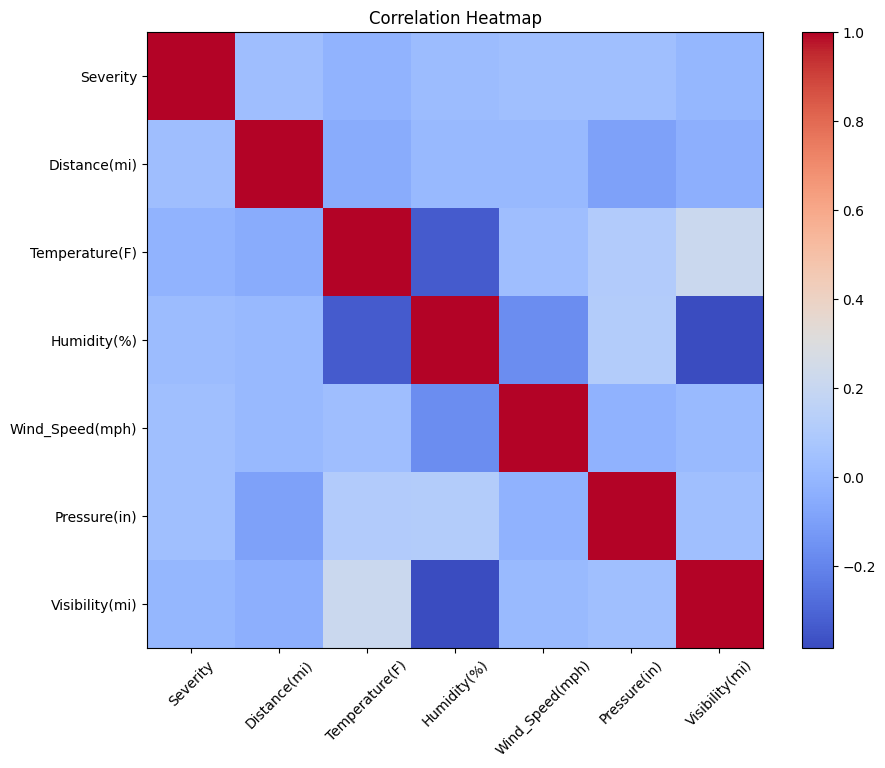

In [ ]:
ddf = full_df

# Select numerical columns (e.g., temperature, humidity, wind_speed)
numerical_columns = ['Severity', 'Distance(mi)','Temperature(F)', 'Humidity(%)', 'Wind_Speed(mph)', 'Pressure(in)', 'Visibility(mi)']

# Compute the correlation matrix (convert to Pandas DataFrame)
correlation_matrix = ddf[numerical_columns].corr().compute()

plt.figure(figsize=(10, 8))
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='nearest')
plt.colorbar()
plt.title("Correlation Heatmap")
plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=45)
plt.yticks(range(len(correlation_matrix.index)), correlation_matrix.index)
plt.show()

[########################################] | 100% Completed | 130.81 s
[########################################] | 100% Completed | 112.25 s


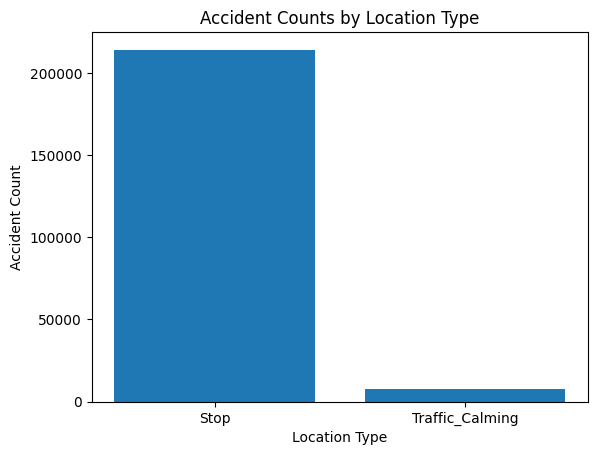

In [ ]:
ddf = full_df

from dask.diagnostics import ProgressBar

# Filter the Dask DataFrame for accidents near 'Stop' and 'Traffic_Calming' locations
stop_accidents = ddf[ddf['Stop'] == 1]
traffic_calming_accidents = ddf[ddf['Traffic_Calming'] == 1]

# Compute the counts using Dask's nunique function and convert to a Pandas Series
with ProgressBar():
    stop_counts = stop_accidents['ID'].nunique().compute()
    traffic_calming_counts = traffic_calming_accidents['ID'].nunique().compute()

# Create a comparative bar chart
fig, ax = plt.subplots()
categories = ['Stop', 'Traffic_Calming']
counts = [stop_counts, traffic_calming_counts]
ax.bar(categories, counts)
ax.set_xlabel('Location Type')
ax.set_ylabel('Accident Count')
ax.set_title('Accident Counts by Location Type')
plt.show()